In [253]:
#theEarliertheBetter
#XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_curve, auc, roc_auc_score)
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [254]:
#importing the data

data = pd.read_csv('/Users/cmoradajr/Downloads/The_Cancer_data_1500_V2.csv')
data.head(5)

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [255]:
#describing the data
print("Descriptive Statistics:")
data.describe()

Descriptive Statistics:


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,0.490667,27.513321,0.269333,0.508667,4.897929,2.417987,0.144000,0.371333
std,17.640968,0.500080,7.230012,0.443761,0.678895,2.866162,1.419318,0.351207,0.483322
min,20.000000,0.000000,15.000291,0.000000,0.000000,0.002410,0.001215,0.000000,0.000000
25%,35.000000,0.000000,21.483134,0.000000,0.000000,2.434609,1.210598,0.000000,0.000000
50%,51.000000,0.000000,27.598494,0.000000,0.000000,4.834316,2.382971,0.000000,0.000000
75%,66.000000,1.000000,33.850837,1.000000,1.000000,7.409896,3.585624,0.000000,1.000000
max,80.000000,1.000000,39.958688,1.000000,2.000000,9.994607,4.987115,1.000000,1.000000


In [256]:
#checking the correlation
data_corr = data.corr()
data_corr

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
Age,1.000000,0.007145,0.030246,-0.013914,-0.027025,0.016396,0.003209,-0.010996,0.196603
Gender,0.007145,1.000000,-0.012516,0.035384,-0.004674,0.023401,0.009723,0.007657,0.250336
BMI,0.030246,-0.012516,1.000000,-0.012616,0.011392,0.011480,0.004711,-0.010824,0.187560
Smoking,-0.013914,0.035384,-0.012616,1.000000,-0.021039,-0.043817,-0.001660,0.016368,0.226999
GeneticRisk,-0.027025,-0.004674,0.011392,-0.021039,1.000000,-0.039721,-0.016864,-0.010833,0.253472
PhysicalActivity,0.016396,0.023401,0.011480,-0.043817,-0.039721,1.000000,0.033856,0.018136,-0.150089
AlcoholIntake,0.003209,0.009723,0.004711,-0.001660,-0.016864,0.033856,1.000000,0.055403,0.212772
CancerHistory,-0.010996,0.007657,-0.010824,0.016368,-0.010833,0.018136,0.055403,1.000000,0.392188
Diagnosis,0.196603,0.250336,0.187560,0.226999,0.253472,-0.150089,0.212772,0.392188,1.000000


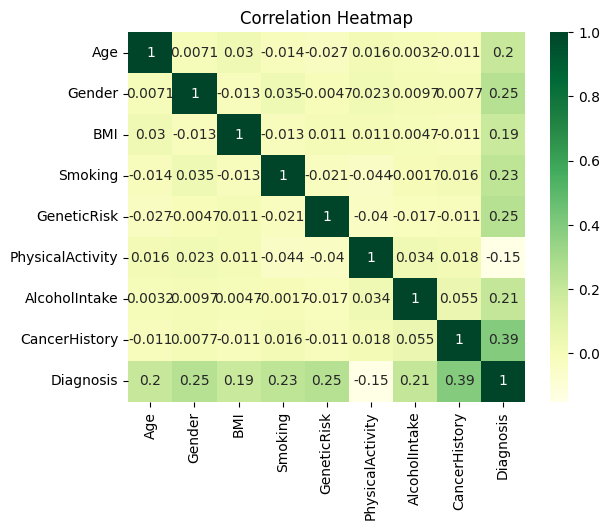

In [257]:
#visualizing the correlation using heatmap
sns.heatmap(data_corr, annot = True, cmap = 'YlGn')
plt.title("Correlation Heatmap")
plt.show()

In [258]:
#defining the variables
X = data.drop('Diagnosis', axis = 1)
y = data['Diagnosis']

In [259]:
#splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45, stratify= y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (1200, 8)
Test set: (300, 8)


In [260]:
#Define Xboost model

xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)

In [261]:
#hyperparameter space for RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}


In [262]:
#randomized search CV

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    scoring='recall',
    cv=5,                # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1          # use all cores
)

In [263]:
#fit the randomized search

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:07] WARN

[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARN

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARN

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=400, reg_alpha=0.01, reg_lambda=3, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=400, reg_alpha=0.01, reg_lambda=3, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=400, reg_alpha=0.01, reg_lambda=3, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=7, n_estimators=400, reg_alpha=0.01, reg_lambda=3, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARN

[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=400, reg_alpha=0.01, reg_lambda=1.5, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=400, reg_alpha=0.01, reg_lambda=1.5, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:08] WARN

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=400, reg_alpha=0.1, reg_lambda=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=400, reg_alpha=0.1, reg_lambda=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=400, reg_alpha=0.1, reg_lambda=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=400, reg_alpha=0.1, reg_lambda=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, n_es

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARN

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=500, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, n_estimato

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARN

[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARN

[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:09] WARN

[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=2, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, n_estimat

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARN

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=4, n_estimators=500, reg_alpha=0.1, reg_lambda=3, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, ma

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARN

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=1, reg_lambda=3, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARN

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, reg_alpha=0.1, reg_lambda=3, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.1, max_depth=6, n_e

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:10] WARN

[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=500, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, m

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARN

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=3, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=3, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=3, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0, reg_lambda=3, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARN

[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=400, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=400, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=400, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=400, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, n_estimator

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARN

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARN

[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=1, reg_lambda=3, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=1, reg_lambda=3, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:11] WARN

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.1, reg_lambda=3, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.1, reg_lambda=3, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=6, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=6, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.1, reg_lambda=3, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.1, reg_lambda=3, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_dep

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARN

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.1, reg_lambda=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_dept

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:12] WARN

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,50
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [264]:
#best parameter and model

print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

Best Parameters: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [265]:
# Initial Predictions
y_pred_initial = best_model.predict(X_test)

# Initial Evaluation
print("\n📊 Initial Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_initial))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_initial))
print("\nClassification Report:\n", classification_report(y_test, y_pred_initial))


📊 Initial Model Performance:
Accuracy: 0.94

Confusion Matrix:
 [[182   7]
 [ 11 100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       189
           1       0.93      0.90      0.92       111

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



In [266]:
#Final model with best parameters

final_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.7,
    gamma=0.3,
    reg_alpha=1,
    reg_lambda=3,
    eval_metric="logloss",
    use_label_encoder=False
)

final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [267]:
#cross validation on final model

cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy')
print("\n📊 Cross-Validation Scores:", cv_scores)
print(f"📊 Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:44:15] WARN


📊 Cross-Validation Scores: [0.94166667 0.93333333 0.90833333 0.9375     0.91666667]
📊 Mean CV Accuracy: 0.9275 (+/- 0.0128)


In [268]:
# Predict on test set
y_pred = final_model.predict(X_test)


🎯 Top 10 Most Important Features:
            feature  importance
7     CancerHistory    0.303466
4       GeneticRisk    0.181745
1            Gender    0.162369
3           Smoking    0.109277
2               BMI    0.066648
0               Age    0.062200
6     AlcoholIntake    0.059428
5  PhysicalActivity    0.054867


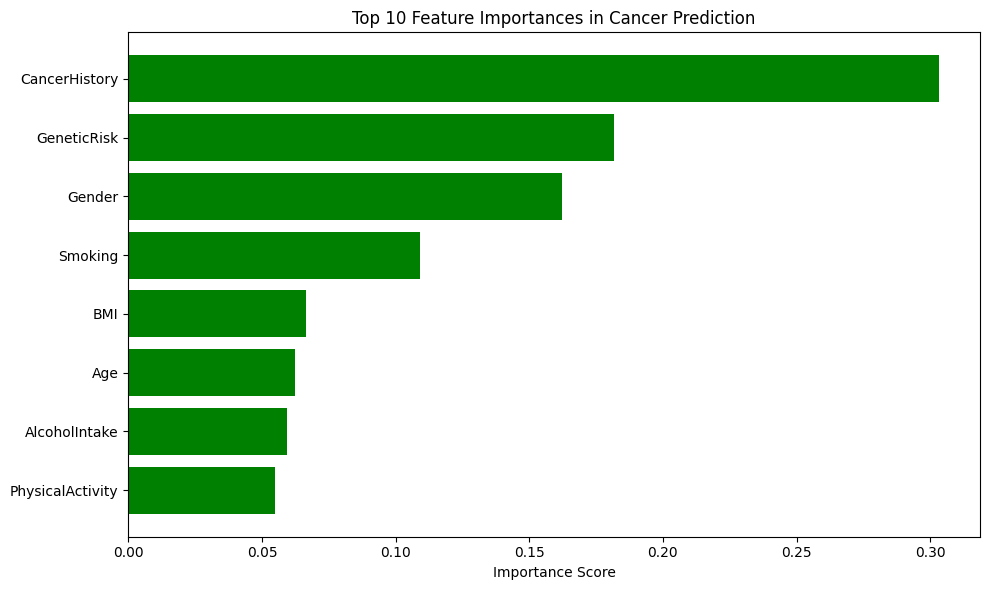

In [269]:
#feature importance

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Top 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], 
         feature_importance['importance'][:10], 
         color='green')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances in Cancer Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [270]:
# Final predictions

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

In [271]:
#Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall:    {round(recall * 100, 2)}%")
print(f"F1-Score:  {round(f1 * 100, 2)}%")
print(f"ROC-AUC:   {round(roc_auc * 100, 2)}%")

print("\n📊 Confusion Matrix:\n", conf_matrix)
print("\n📄 Classification Report:\n", report)


FINAL MODEL PERFORMANCE
Accuracy:  94.0%
Precision: 93.46%
Recall:    90.09%
F1-Score:  91.74%
ROC-AUC:   97.59%

📊 Confusion Matrix:
 [[182   7]
 [ 11 100]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       189
           1       0.93      0.90      0.92       111

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



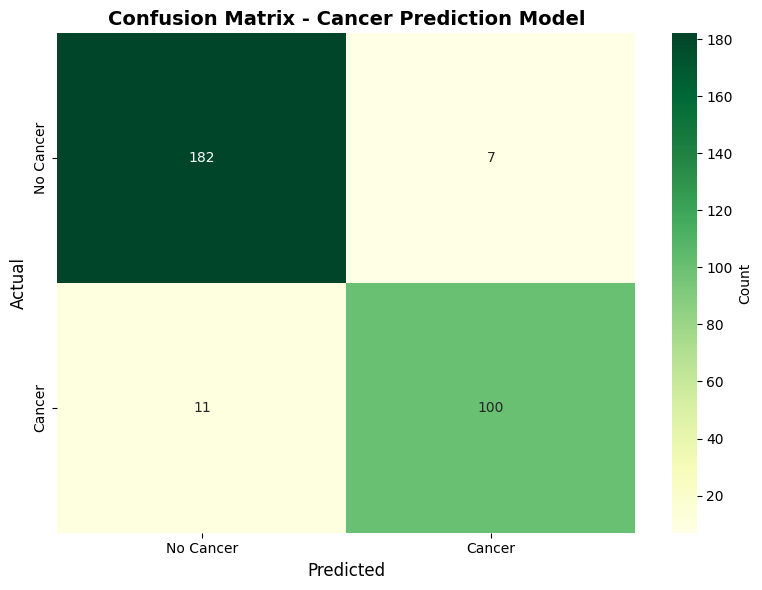

In [272]:
#visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', 
            xticklabels=["No Cancer", "Cancer"],  
            yticklabels=["No Cancer", "Cancer"],  
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Cancer Prediction Model", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [273]:
# Interpretation:

# The model correctly predicted 182 patients without cancer.
# It incorrectly predicted 7 patients as having cancer when they do not.
# It failed to predict 11 patients who actually had cancer.
# It correctly predicted 100 patients with cancer.